In [1]:
from adjustable_efficient_qsp import *
from adjustable_efficient_non_unitary import *
from qiskit.tools.visualization import *
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

fig = plt.figure()
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "font.size": 12
})

<Figure size 640x480 with 0 Axes>

In [2]:
# Initial state function
def init(x):
    epsilon0 = 1/10
    return np.exp(-(x-0.5)**2*100)*epsilon0

# Generates the list of size n_operators containing the indices of Walsh operators with highest coefficients
def get_max_coeffs(n,n_operators,f):
    walsh_coeffs = {}
    for i in range(2**n):
        walsh_coeffs[i] = abs(walsh_coeff(i,f,2**n))
    w = sorted(walsh_coeffs.items(), key=lambda x:x[1],reverse=True)
    list_operator_to_implement = list(dict(w).keys())[:n_operators]
    return list_operator_to_implement

def get_max_coeffs_non_unitary(n,n_operators,f,d,decomposition):
    coeffs = {}
    f_mean = 0
    for i in range(2**n):
        f_mean += sequential_coeff_non_unitary(i,f,2**n,d)/2**n
    
    for i in range(2**n):
        if decomposition=='walsh':
            coeffs[i] = abs(walsh_coeff_non_unitary(i,f,2**n,d))
        else:
            coeffs[i] = abs(sequential_coeff_non_unitary(i,f,2**n,d)-f_mean)
    w = sorted(coeffs.items(), key=lambda x:x[1],reverse=True)
    list_operator_to_implement = list(dict(w).keys())[:n_operators]
    return list_operator_to_implement

## Heat equation with Walsh decomposition

Text(0.5, 1.0, 'Diffusion equation resolution')

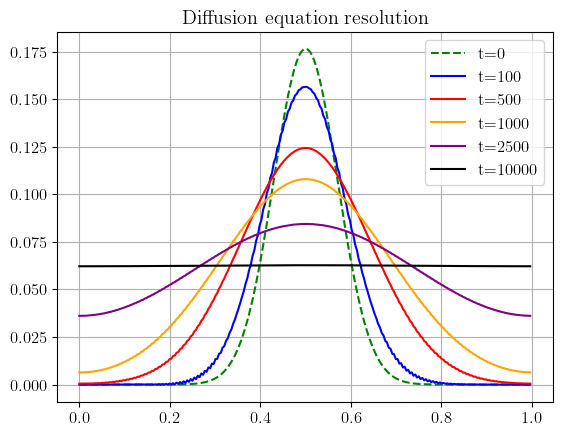

In [3]:
n = 8
n_ancilla_diag = 0
n_ancilla_qsp = 0
gray_code = True

# Number of Walsh operators to implement for the QSP step, max value is 2**n
n_walsh_operators_qsp = 32
list_operator_to_implement_qsp = get_max_coeffs(n,n_walsh_operators_qsp,init)
qsp_walsh = qsp(n,init,n_ancilla_diag,n_ancilla_qsp,list_operator_to_implement_qsp,decomposition='walsh',gray_code=gray_code,swaps=True)

# Number of Walsh operators to implement for the non_unitary step, max value is 2**n
n_walsh_operators_non_unitary = 128

t_list = [100,500,1000,2500,10000]
color_list = ['blue','red','orange','purple','black']

QFT_gate = QFT(n,do_swaps=False)

X = np.array(range(2**n))/(2**n)
plt.plot(X,init(X)/np.linalg.norm(init(X)),marker='',c='g',linestyle='--',label='t=0')
    
for k in range(5):
    t = t_list[k]
    color = color_list[k]
    
    q = QuantumRegister(n,name='q')
    qA = QuantumRegister(1,name='qA')
    qB = QuantumRegister(1,name='qB')
    a = AncillaRegister(n_ancilla_diag,name='a')
    a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
    qc = QuantumCircuit(q,qB,qA,a,a_qsp)
    
    q_qubits = qc.qubits[:n]
    qB_qubits = qc.qubits[n:n+1]
    qA_qubits = qc.qubits[n+1:n+2]
    a_qubits = qc.qubits[n+2:n+2+n_ancilla_diag]
    a_qsp_qubits = qc.qubits[n+2+n_ancilla_diag:n+2+n_ancilla_diag+n+2+n_ancilla_qsp]

    # QSP step
    qc.h(q)
    qc.append(qsp_walsh,q_qubits+qA_qubits+a_qubits+a_qsp_qubits)
    
    # Non-unitary step
    def f(x,d,dmax):
        return np.arccos(d(x)/(2*dmax))
    
    
    def d(x):
        kappa = 1
        return np.exp(-t*kappa*np.sin(2*np.pi*(x-0.5))**2)

    list_operator_to_implement_non_unitary = get_max_coeffs_non_unitary(n,n_walsh_operators_non_unitary,f,d,'walsh')
    non_unitary_walsh = non_unitary(n,f,d,n_ancilla_diag,n_ancilla_qsp,list_operator_to_implement_non_unitary,decomposition='walsh',gray_code=gray_code,swaps=False)
    qc.append(QFT_gate,q_qubits)
    qc.append(non_unitary_walsh,q_qubits+qB_qubits+a_qubits+a_qsp_qubits)
    qc.append(QFT_gate.inverse(),q_qubits)
    
    dmax = get_dmax(d,2**n)
    state = qi.Statevector.from_instruction(qc)
    state_dict = state.to_dict()
    data = []
    n_bits = len(list(state_dict.keys())[0])
    for i in list(state_dict.keys()):
        if i[n_bits-n-1] == '0' and i[n_bits-n-2] == '1':
            data.append(state_dict[i])
    L = np.array(data)
    plt.plot(X,np.real(L)/np.linalg.norm(L),marker='',linestyle='-',c=color,label='t='+str(t))
    
plt.legend()
plt.grid()
plt.title('Diffusion equation resolution')

## Heat equation with Sequential-Walsh decomposition

7.426574383904762e-05
6.48350786537825e-05
4.89886269441135e-05
4.582301015856462e-05
1.9554267233138446e-05


Text(0.5, 1.0, 'Diffusion equation resolution')

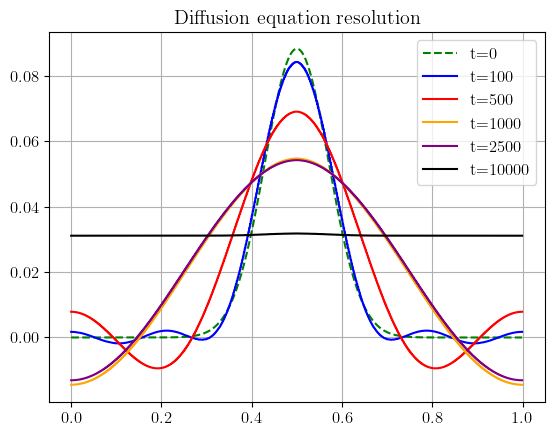

In [36]:
import numpy as np
import matplotlib.pyplot as plt

n = 10
n_ancilla_diag = 0
n_ancilla_qsp = 0
gray_code = True

# Number of Walsh operators to implement for the QSP step, max value is 2**n
n_walsh_operators_qsp = 32
list_operator_to_implement_qsp = get_max_coeffs(n,n_walsh_operators_qsp,init)
qsp_walsh = qsp(n,init,n_ancilla_diag,n_ancilla_qsp,list_operator_to_implement_qsp,decomposition='walsh',gray_code=gray_code,swaps=True)

t_list = [100,500,1000,2500,10000]
list_n_sequential_operators_non_unitary = [20,10,6,6,2]
list_n_walsh_operators_non_unitary = [4,4,1,1,1]

color_list = ['blue','red','orange','purple','black']

QFT_gate = QFT(n,do_swaps=False)

X = np.array(range(2**n))/(2**n)
plt.plot(X,init(X)/np.linalg.norm(init(X)),marker='',c='g',linestyle='--',label='t=0')
    
for k in range(len(t_list)):
    t = t_list[k]
    color = color_list[k]
    n_sequential_operators_non_unitary = list_n_sequential_operators_non_unitary[k]
    n_walsh_operators_non_unitary = list_n_walsh_operators_non_unitary[k]
    
    q = QuantumRegister(n,name='q')
    qA = QuantumRegister(1,name='qA')
    qB = QuantumRegister(1,name='qB')
    a = AncillaRegister(n_ancilla_diag,name='a')
    a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
    qc = QuantumCircuit(q,qB,qA,a,a_qsp)

    q_qubits = qc.qubits[:n]
    qB_qubits = qc.qubits[n:n+1]
    qA_qubits = qc.qubits[n+1:n+2]
    a_qubits = qc.qubits[n+2:n+2+n_ancilla_diag]
    a_qsp_qubits = qc.qubits[n+2+n_ancilla_diag:n+2+n_ancilla_diag+n+2+n_ancilla_qsp]

    # QSP step
    qc.h(q)
    qc.append(qsp_walsh,q_qubits+qA_qubits+a_qubits+a_qsp_qubits)
    
    # non unitary

    def d(x):
        kappa = 1
        return np.exp(-t*kappa*np.sin(2*np.pi*(x-0.5))**2)

    dmax = get_dmax(d,2**n)

    def f(x,d,dmax):
        return np.arccos(d(x)/(2*dmax))

    def listcreationd1d2(n,f,d,n_sequential_operators_non_unitary):
        l = {}
        f_mean = 0
        for i in range(2**n):
            f_mean += f(i/2**n,d,dmax)/2**n

        for i in range(2**n):
            l[i] = abs(f(i/2**n,d,dmax)-f_mean)
        l_sorted = dict(sorted(l.items(), key=lambda x:x[1],reverse=True)[:n_sequential_operators_non_unitary])

        listd2 = []
        listd1 = []
        for i in range(2**n):
            if i in list(l_sorted.keys()):
                listd2.append(f_mean)
                listd1.append(f(i/2**n,d,dmax)-f_mean)
            else:
                listd2.append(f(i/2**n,d,dmax))
                listd1.append(0)
        return np.array(listd1),np.array(listd2)

    X = np.array(range(2**n))/(2**n)

    listd1,listd2 = listcreationd1d2(n,f,d,n_sequential_operators_non_unitary)

    # get max coeffs of d2
    walsh_coeffs = {}
    for i in range(2**n):
        walsh_coeffs[i] = abs(listd2[i])
    #w = sorted(walsh_coeffs.items(), key=lambda x:x[1],reverse=True)
    #list_walsh_operator_to_implement_non_unitary = list(dict(w).keys())[:n_walsh_operators_non_unitary]
    list_walsh_operator_to_implement_non_unitary = [i for i in range(len(t_list))]
    # get max coeffs of d1
    list_sequential_operator_to_implement_non_unitary = []
    for i in range(len(listd1)):
        if listd1[i] != 0:
            list_sequential_operator_to_implement_non_unitary.append(i)
    non_unitary_sequential = non_unitary(n,listd1,d,n_ancilla_diag,n_ancilla_qsp,list_sequential_operator_to_implement_non_unitary,decomposition='sequential',gray_code=gray_code,swaps=True)
    non_unitary_walsh = non_unitary(n,listd2,d,n_ancilla_diag,n_ancilla_qsp,list_walsh_operator_to_implement_non_unitary,decomposition='walsh',gray_code=gray_code,swaps=False)
    qc.append(QFT_gate,q_qubits)
    qc.append(non_unitary_sequential,q_qubits+qB_qubits+a_qubits+a_qsp_qubits)
    qc.append(non_unitary_walsh,q_qubits+qB_qubits+a_qubits+a_qsp_qubits)
    qc.append(QFT_gate.inverse(),q_qubits)
    
    dmax = get_dmax(d,2**n)
    state = qi.Statevector.from_instruction(qc)
    state_dict = state.to_dict()
    data = []
    n_bits = len(list(state_dict.keys())[0])
    for i in list(state_dict.keys()):
        if i[n_bits-n-1] == '0' and i[n_bits-n-2] == '1':
            data.append(state_dict[i])
    L = np.array(data)
    print(np.linalg.norm(L)**2)
    plt.plot(X,np.real(L)/np.linalg.norm(L),marker='',linestyle='-',c=color,label='t='+str(t))
    
plt.legend()
plt.grid()
plt.title('Diffusion equation resolution')
#qc.decompose(reps=4).draw()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n = 8
n_ancilla_diag = 0
n_ancilla_qsp = 0
gray_code = True

# Number of Walsh operators to implement for the QSP step, max value is 2**n
n_walsh_operators_qsp = 2**n
list_operator_to_implement_qsp = get_max_coeffs(n,n_walsh_operators_qsp,init)
qsp_walsh = qsp(n,init,n_ancilla_diag,n_ancilla_qsp,list_operator_to_implement_qsp,decomposition='walsh',gray_code=gray_code,swaps=True)

t_list = [100,500,1000,2500,10000]
list_n_sequential_operators_non_unitary = [20,10,6,4,2]
list_n_walsh_operators_non_unitary = [4,2,1,1,1]

color_list = ['blue','red','orange','purple','black']

QFT_gate = QFT(n,do_swaps=False)

X = np.array(range(2**n))/(2**n)
plt.plot(X,init(X)/np.linalg.norm(init(X)),marker='',c='g',linestyle='--',label='t=0')
    
for k in range(len(t_list)):
    t = t_list[k]
    color = color_list[k]
    n_sequential_operators_non_unitary = list_n_sequential_operators_non_unitary[k]
    n_walsh_operators_non_unitary = list_n_walsh_operators_non_unitary[k]
    
    q = QuantumRegister(n,name='q')
    qA = QuantumRegister(1,name='qA')
    qB = QuantumRegister(1,name='qB')
    a = AncillaRegister(n_ancilla_diag,name='a')
    a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
    qc = QuantumCircuit(q,qB,qA,a,a_qsp)

    q_qubits = qc.qubits[:n]
    qB_qubits = qc.qubits[n:n+1]
    qA_qubits = qc.qubits[n+1:n+2]
    a_qubits = qc.qubits[n+2:n+2+n_ancilla_diag]
    a_qsp_qubits = qc.qubits[n+2+n_ancilla_diag:n+2+n_ancilla_diag+n+2+n_ancilla_qsp]

    # QSP step
    qc.h(q)
    qc.append(qsp_walsh,q_qubits+qA_qubits+a_qubits+a_qsp_qubits)
    
    # non unitary

    def d(x):
        kappa = 1
        return np.exp(-t*kappa*np.sin(2*np.pi*(x-0.5))**2)

    dmax = get_dmax(d,2**n)

    def f(x,d,dmax):
        return np.arccos(d(x)/(2*dmax))

    def listcreationd1d2(n,f,d,n_sequential_operators_non_unitary):
        l = {}
        f_mean = 0
        for i in range(2**n):
            f_mean += f(i/2**n,d,dmax)/2**n

        for i in range(2**n):
            l[i] = abs(f(i/2**n,d,dmax)-f_mean)
        l_sorted = dict(sorted(l.items(), key=lambda x:x[1],reverse=True)[:n_sequential_operators_non_unitary])

        listd2 = []
        listd1 = []
        for i in range(2**n):
            if i in list(l_sorted.keys()):
                listd2.append(f_mean)
                listd1.append(f(i/2**n,d,dmax)-f_mean)
            else:
                listd2.append(f(i/2**n,d,dmax))
                listd1.append(0)
        return np.array(listd1),np.array(listd2)

    X = np.array(range(2**n))/(2**n)

    listd1,listd2 = listcreationd1d2(n,f,d,n_sequential_operators_non_unitary)

    # get max coeffs of d2
    walsh_coeffs = {}
    for i in range(2**n):
        walsh_coeffs[i] = abs(listd2[i])
    w = sorted(walsh_coeffs.items(), key=lambda x:x[1],reverse=True)
    list_walsh_operator_to_implement_non_unitary = list(dict(w).keys())[:n_walsh_operators_non_unitary]
    # get max coeffs of d1
    list_sequential_operator_to_implement_non_unitary = []
    for i in range(len(listd1)):
        if listd1[i] != 0:
            list_sequential_operator_to_implement_non_unitary.append(i)
            
    non_unitary_walsh = non_unitary(n,listd2,d,n_ancilla_diag,n_ancilla_qsp,list_walsh_operator_to_implement_non_unitary,decomposition='walsh',gray_code=gray_code,swaps=True)
    non_unitary_sequential = non_unitary(n,listd1,d,n_ancilla_diag,n_ancilla_qsp,list_sequential_operator_to_implement_non_unitary,decomposition='sequential',gray_code=gray_code,swaps=False)
    qc.append(QFT_gate,q_qubits)
    #qc.append(non_unitary_sequential,q_qubits+qB_qubits+a_qubits+a_qsp_qubits)
    qc.h(qB)
    #qc.append(non_unitary_walsh,q_qubits+qB_qubits+a_qubits+a_qsp_qubits)
    qc.append(QFT_gate.inverse(),q_qubits)
    
    dmax = get_dmax(d,2**n)
    state = qi.Statevector.from_instruction(qc)
    state_dict = state.to_dict()
    data = []
    n_bits = len(list(state_dict.keys())[0])
    for i in list(state_dict.keys()):
        if i[n_bits-n-1] == '0' and i[n_bits-n-2] == '1':
            data.append(state_dict[i])
    L = np.array(data)
    plt.plot(X,np.real(L)/np.linalg.norm(L),marker='',linestyle='-',c=color,label='t='+str(t))
    
plt.grid()
plt.legend()